In [1]:
import sys
import numpy as np
sys.path.append('../')
from src.d06_reporting.sample_evaluation import SampleEvaluation
from src.d04_modeling.propositional_classifier import PropositionalClassifier, andClassifier, orClassifier

# Sample Evaluation

Loading Block FRL data...0.1884
Loading Block Demographic data...0.2016
Loading Student Demographic data...1.4419
Propositional Statement:
pctBoth >=  {0:.2f}
Focal group: nBoth
Loading Block FRL data...0.2068
Loading Block Demographic data...0.2174
Loading Student Demographic data...1.0768
Propositional Statement:
pctBoth >=  {0:.2f}
Focal group: nBoth


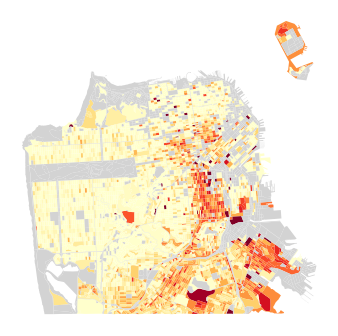

In [5]:
positive_group = 'nBoth'

report = dict()
for frl_key in ['tk5', 'tk12']:
    eligibility_classifier = orClassifier(["Housing", "Redline"], binary_var=[0,1])
    propositional_model = andClassifier(["pctBoth"], positive_group=positive_group, eligibility_classifier=eligibility_classifier, frl_key=frl_key)
    propositional_params = np.linspace(0.,1., 100)
    report[frl_key] = SampleEvaluation(frl_key=frl_key, propositional_model=propositional_model, propositional_params=propositional_params)

report['tk5'].heat_map1(column='pctBoth', pct_frl=True, title="Focal (%)")







# Evaluation of Tiebreakers

We are going to consider two methodologies to evaluate different tiebreakers: sample evaluation and counterfactual simulation.

## Sample Evaluation

The sample evaluation consists on comparing the portion of _focal_ students benefited with the equity tiebreaker (true positive rate) with the portion of _non-focal_students_ (false positives).

`TPR = TP / (TP + FN)`

`FNR = FP / (FP + TN)`

## Counterfactual Simulation

The counterfactual simulation consists of using the school assignment simulation engine to evaluate and compare the average performance of _focal_ students in the school assignment process under the proposed equity tiebreaker. This is what is important after all.

### Tiebreaker Methodologies

#### Naive

Order the blocks by how many focal students they have. We consider two orderings, by absolute number of students and by relative number of students (`rate=True`). By relative number of students we mean the proportion of focal students within the block.

#### CTIP1

A student is labeled as _focal_ if they live in a block that belongs to the first CTIP quintile. This is the baseline.

#### Knapsack Problem

We model the process of selecting or labeling the blocks as a Knapsack Problem. The [Knapsack Problem](https://en.wikipedia.org/wiki/Knapsack_problem) is a problem in combinatorial optimization: Given a set of items, each with a weight and a value, determine which items to include in a collection so that the total weight is less than or equal to a given limit, and the total value is as large as possible.

Under this formulation, the items we are trying to select are the blocks, and the values and weights are the numbers of _focal_  and _non-focal_ students in that block, respectively. The limit on the total weight is our tolerance to the total number of _non-focal_ students that obtain the equity tiebreaker. In other words, this limit is the number of false positives (FP) and is equal to the FPR times the total number of _non-focal_ students (N).

We expect the block selection obtained by this method to yield the maximum TPR for a given FPR.

#### Propositions


# Sample Evaluation Results

## TK12

First, we evaluated the classification models using the data provided by SFUSD for the counts of focal students from TK12. This data includes the counts of African American, Latinx, and Pacific Islander (AALPI) students and Free or Reduced Lunch (FRL) students for each block. The SFUSD team grouped blocks with less than five students.

CTIP1 FPR: 0.1354
Parameters DSSG ET @ 0.1354:
0.393939393939394


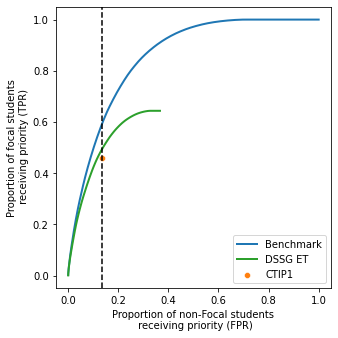

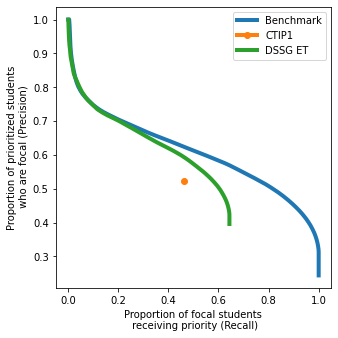

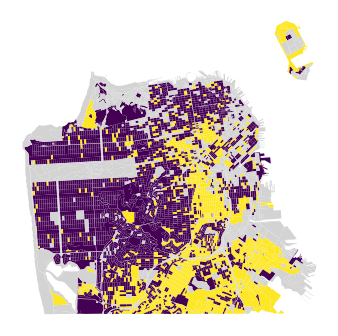

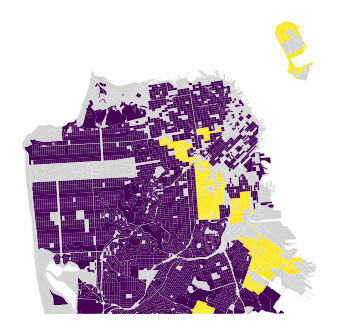

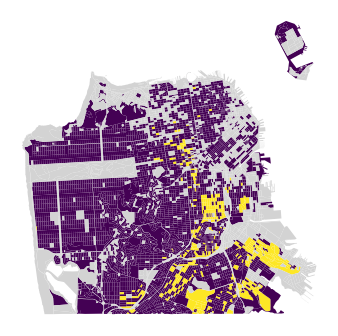

In [8]:
# Plot the ROC curves for different models for the TK12 FRL and AALPI data and the proposition:
frl_key = 'tk12'
fpr = report[frl_key].get_ctip1_fpr()
params = report[frl_key].get_dssg_et_params(fpr)
report[frl_key].classifier_evalutaion_roc(x=fpr)
report[frl_key].classifier_evalutaion_precision_recall()
report[frl_key].classification_map(fpr=fpr, params=params)

## TK5

We alsoe evaluated the classification models using the data provided by SFUSD for the counts of focal students from TK5.

CTIP1 FPR: 0.1596
Parameters DSSG ET @ 0.1596:
0.31313131313131315


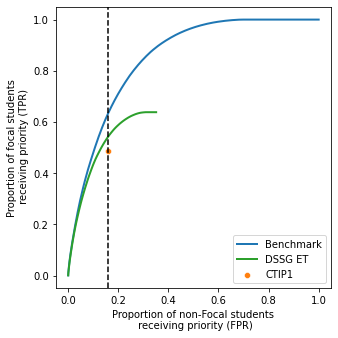

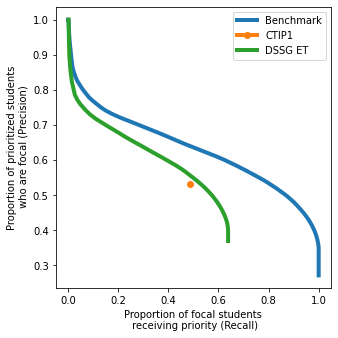

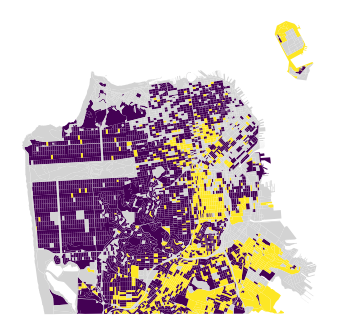

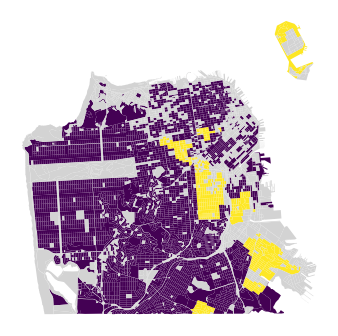

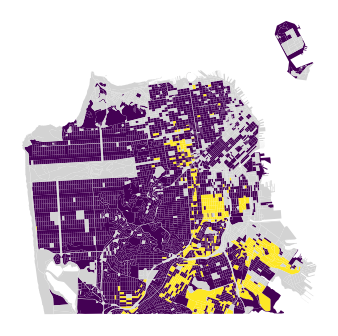

In [9]:
# Plot the ROC curves for different models for the TK12 FRL and AALPI data and the proposition:
frl_key = 'tk5'
fpr = report[frl_key].get_ctip1_fpr()
params = report[frl_key].get_dssg_et_params(fpr)
report[frl_key].classifier_evalutaion_roc(x=fpr)
report[frl_key].classifier_evalutaion_precision_recall()
report[frl_key].classification_map(fpr=fpr, params=params)